# 🩺 Stroke Prediction: End-to-End Machine Learning Pipeline

# 1. Import Libraries
Import all necessary libraries for data processing, modeling, and visualization

In [24]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score,cross_val_predict
from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler
from sklearn.metrics import f1_score, classification_report,ConfusionMatrixDisplay, confusion_matrix,roc_auc_score,roc_curve, auc
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import StackingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import shap
import joblib
import seaborn as sns
from ydata_profiling import ProfileReport
%matplotlib inline

In [25]:
# Configuration file for paths and constants
sys.path.append(os.path.abspath(".."))
from config import DATA_RAW_PATH, DATA_PREDICTED_PATH,DATA_PROCESSED_PATH, MODEL_DIR, TRAIN_FILE, TEST_FILE,TRAIN_PREPROCESSED_FILE,TEST_PREPROCESSED_FILE, SAMPLE_SUBMISSION_FILE, RANDOM_STATE,SCALING_FILE_NAME
from src.file_handler import FileHandler

In [26]:
import warnings
warnings.filterwarnings('ignore')

## 2. Dataset Meta Information

**Files:**
- `train.csv`: Data containing all available features and the stroke response.
- `test.csv`: Unseen stroke patients with all available predictors but missing stroke. Used for model prediction.
- `sample_submission.csv`: A sample submission file in the correct format.

**Data Dictionary:**
| Column            | Type     | Description                                                                                 | Values/Range                        |
|-------------------|----------|---------------------------------------------------------------------------------------------|-------------------------------------|
| `id`              | Integer  | Unique identifier for each record                                                            | Any integer                         |
| `gender`          | String   | Gender of the patient                                                                       | `Male`, `Female`                    |
| `age`             | Float    | Age of the patient in years                                                                 | Any positive float                  |
| `hypertension`    | Integer  | Indicates whether the patient has hypertension                                              | `0`: No, `1`: Yes                   |
| `heart_disease`   | Integer  | Indicates whether the patient has heart disease                                             | `0`: No, `1`: Yes                   |
| `ever_married`    | String   | Marital status of the patient                                                               | `Yes`, `No`                         |
| `work_type`       | String   | Type of employment                                                                          | `Private`, `Self-employed`, `Govt_job`, `Children`, etc. |
| `Residence_type`  | String   | Type of residence                                                                          | `Urban`, `Rural`                    |
| `avg_glucose_level`| Float   | Average glucose level of the patient (mg/dL)                                                | Any positive float                  |
| `bmi`             | Float    | Body Mass Index (BMI) of the patient                                                        | Any positive float                  |
| `smoking_status`  | String   | Smoking status                                                                             | `never smoked`, `formerly smoked`, `smokes`, `Unknown` |
| `stroke`          | Integer  | Target variable indicating whether the patient had a stroke (**[TARGET]**)                  | `0`: No, `1`: Yes                   |

# 3. Load Data
 Load training and test datasets

In [27]:
# Load the training data
train = FileHandler.read_data(DATA_RAW_PATH, TRAIN_FILE)
# Load the test data
test = FileHandler.read_data(DATA_RAW_PATH, TEST_FILE)
# Load the sample submission file
sample_solution = FileHandler.read_data(DATA_RAW_PATH, SAMPLE_SUBMISSION_FILE)

# Create copies of the original train and test data
# This is useful for keeping the original data intact for future reference or comparisons
orgnigal_train=train.copy(deep=True)
orgnigal_test=test.copy(deep=True)

# 4. Exploratory Data Analysis (EDA)

**4.1 Check dataset shape**

In [28]:
print("Train Data Shape:", train.shape)
print("Test Data Shape:", test.shape)

Train Data Shape: (12243, 12)
Test Data Shape: (3061, 11)


**4.2   Check dataset meta info**  

    Display data types and missing values

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12243 entries, 0 to 12242
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 12243 non-null  int64  
 1   gender             12243 non-null  object 
 2   age                12243 non-null  float64
 3   hypertension       12243 non-null  int64  
 4   heart_disease      12243 non-null  int64  
 5   ever_married       12243 non-null  object 
 6   work_type          12243 non-null  object 
 7   Residence_type     12243 non-null  object 
 8   avg_glucose_level  12243 non-null  float64
 9   bmi                12243 non-null  float64
 10  smoking_status     12243 non-null  object 
 11  stroke             12243 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.1+ MB


**4.3 Statistical Summary**  

Show summary statistics for numerical features

In [30]:
train.describe(percentiles=[0.05,0.25, 0.5, 0.75,0,0.99])

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,12243.000000,12243.000000,12243.000000,12243.000000,12243.000000,12243.000000,12243.00000
mean,6122.000000,41.344951,0.049416,0.023279,88.820804,28.074400,0.04133
std,3534.394007,21.518463,0.216744,0.150793,24.957986,6.707892,0.19906
min,1.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.00000
0%,1.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.00000
5%,613.100000,4.000000,0.000000,0.000000,60.980000,17.900000,0.00000
25%,3061.500000,25.000000,0.000000,0.000000,74.880000,23.500000,0.00000
50%,6122.000000,43.000000,0.000000,0.000000,85.030000,27.600000,0.00000
75%,9182.500000,57.000000,0.000000,0.000000,96.840000,31.900000,0.00000
99%,12120.580000,81.000000,1.000000,1.000000,215.848800,46.900000,1.00000


**4.4 View Sample Data**  
Display the first few rows of the training data

In [31]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,Male,50.0,0,0,Yes,Private,Rural,88.10,29.1,formerly smoked,0
1,2,Female,52.0,0,0,Yes,Private,Rural,80.07,38.9,smokes,0
2,3,Female,26.0,0,0,No,Govt_job,Urban,89.11,23.3,smokes,0
3,4,Female,37.0,0,0,Yes,Private,Rural,81.36,36.1,never smoked,0
4,5,Male,59.0,0,0,Yes,Private,Rural,82.59,29.6,never smoked,1


**4.5 Check missing values**

In [32]:
print("Missing values in train data:")
print(train.isnull().sum())
print("\n")
print("Missing values in test data:")
print(test.isnull().sum())

Missing values in train data:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


Missing values in test data:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64


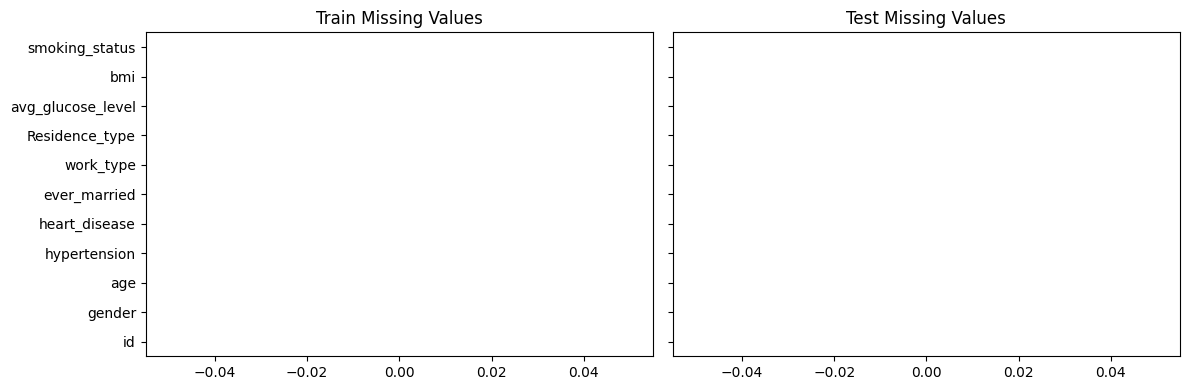

In [33]:
# Visualize missing values in train data
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
train.isna().sum().plot.barh(ax=axes[0], color='skyblue')
test.isna().sum().plot.barh(ax=axes[1], color='salmon')
axes[0].set_title('Train Missing Values')
axes[1].set_title('Test Missing Values')
plt.tight_layout()
plt.show()

* observation: no missing value for train and test dataset

**4.6 Data Profiling**  
 Generate an automated profiling report for EDA

In [34]:
profile = ProfileReport(train, title="Stroke Prediction Dataset Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 76.80it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**4.7 Categorizing features based on data types**

In [35]:
# Categorical and numerical columns
# These lists categorize the features based on their data types
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
cat_binary_cols = ['hypertension', 'heart_disease']
num_cols= ['age', 'avg_glucose_level', 'bmi']

**4.8 Target Variable Distribution check and visualize**  
 

In [36]:
# Check for unique values in categorical columns
print("Stroke Value Counts:")
print(train['stroke'].value_counts())
print("\nStroke Percentage Distribution:")
print(train['stroke'].value_counts(normalize=True) * 100)

Stroke Value Counts:
stroke
0    11737
1      506
Name: count, dtype: int64

Stroke Percentage Distribution:
stroke
0    95.867026
1     4.132974
Name: proportion, dtype: float64


**4.9 Visualize imbalance in the target variable**  

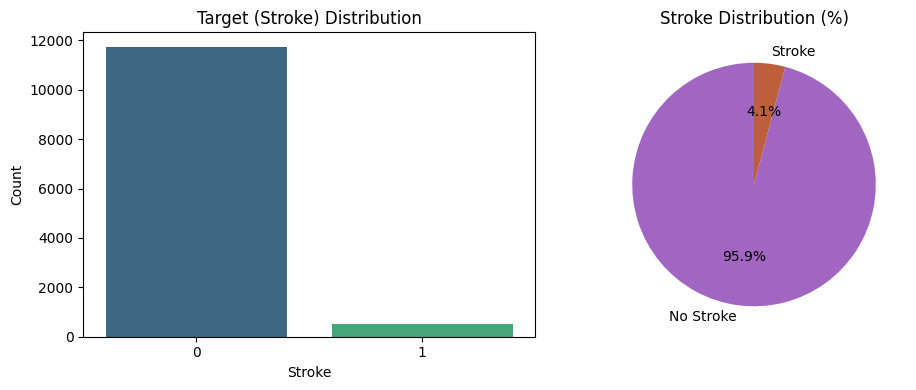

In [37]:
# Visualize the distribution of the target variable (stroke)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
sns.countplot(x='stroke', data=train, ax=axes[0], palette='viridis')
axes[0].set_title('Target (Stroke) Distribution')
axes[0].set_xlabel('Stroke')
axes[0].set_ylabel('Count')

axes[1].pie(
    train['stroke'].value_counts(normalize=True),
    labels=['No Stroke', 'Stroke'],
    autopct='%1.1f%%',
    startangle=90,
    colors=["#a066c2", "#bc5f3a"]
)
axes[1].set_title('Stroke Distribution (%)')
plt.tight_layout()
plt.show()


* Observation: The target(stroke) is highly imbalance for training

**4.10 Check the scewness of numerical features**

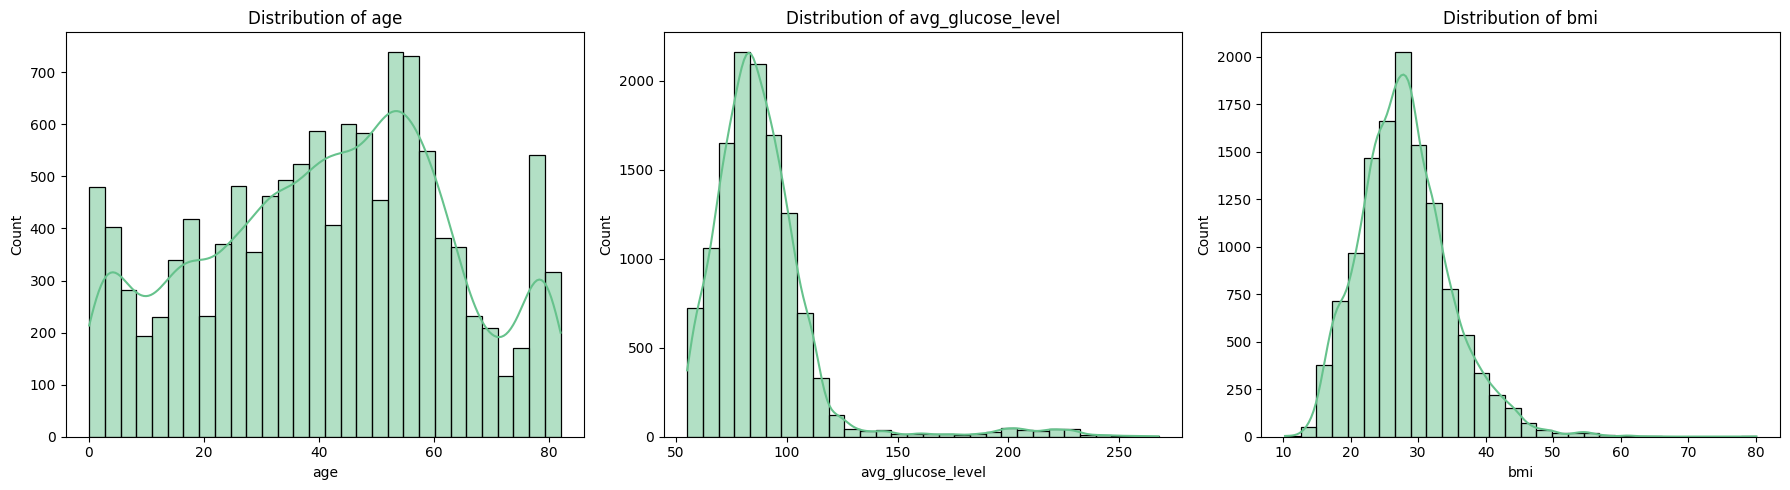

In [38]:
# Check the scewness of numerical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(num_cols):
    sns.histplot(data=train, x=col, kde=True, bins=30, ax=axes[i], color="#66c28c")
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

* **Observation** : The BMI and avg_clucose_level are rightly screwed

**4.11 Check the outliers in the numerical features**

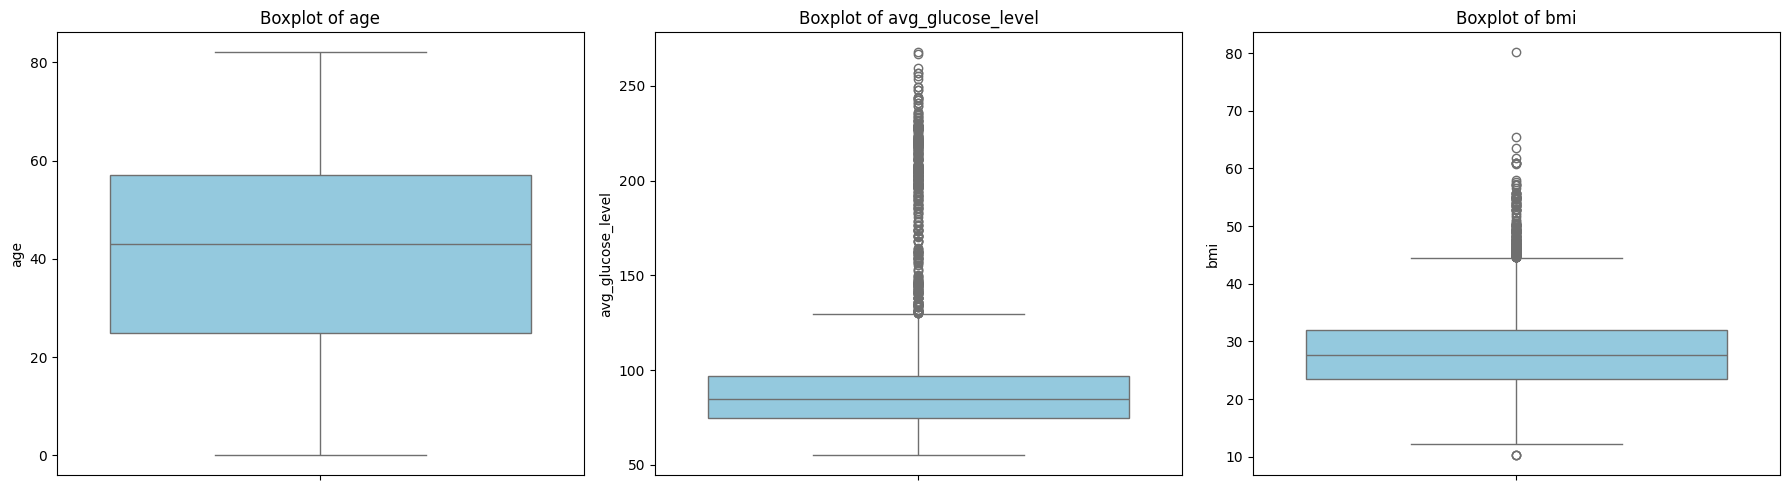

In [39]:
# Check the outliers in numerical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(num_cols):
    sns.boxplot(data=train, y=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()

In [40]:
# Check the outliers in numerical features
for col in num_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    # Finding IQR
    IQR = (Q3 - Q1)
    da=(train[col] < (Q1 - 1.5 * IQR)) | (train[col] > (Q3 + 1.5 * IQR))
    print(f"\nOutliers in {col}:\n")
    print(da.value_counts())
    print(f"Percentage of outliers in {col}: {da.mean() * 100:.2f}%")
    print(f"Percentage of outliers with stroke: {len(train[da & train['stroke']==1]) / len(train) * 100:.2f}%")

    # Finding extreme outliers
    # Extreme outliers are defined as values below the 1st percentile or above the 99th percentile
    lower = train[col].quantile(0.01)
    upper = train[col].quantile(0.99)
    extream_outlier = train[(train[col] <= lower) & (train[col] >= upper)]
    print(f"Percentage of extreme outliers in {col}: {len(extream_outlier)} ({len(extream_outlier) / len(train) * 100:.3f})%\n")


Outliers in age:

age
False    12243
Name: count, dtype: int64
Percentage of outliers in age: 0.00%
Percentage of outliers with stroke: 0.00%
Percentage of extreme outliers in age: 0 (0.000)%


Outliers in avg_glucose_level:

avg_glucose_level
False    11824
True       419
Name: count, dtype: int64
Percentage of outliers in avg_glucose_level: 3.42%
Percentage of outliers with stroke: 0.69%
Percentage of extreme outliers in avg_glucose_level: 0 (0.000)%


Outliers in bmi:

bmi
False    12033
True       210
Name: count, dtype: int64
Percentage of outliers in bmi: 1.72%
Percentage of outliers with stroke: 0.08%
Percentage of extreme outliers in bmi: 0 (0.000)%



* **Observation:** 
* BMI has 210(1.71%) outliers 
* avg_glucose_level has 419(3.42%) outliers
* Percentage of outliers of bmi with stroke is 0.08% and avg_glucose_level is 3.42%
* Since it has outliers standard scaler may stretch the scale, leading to shrunken "normal" values. Impact model performance, especially for algorithms like SVM, KNN, and Logistic Regression
* RobustScaler uses the median and IQR (interquartile range) — it is resistant to outliers
* No extream outliers observed
 

**4.12 Categorical Features: Count Plots**

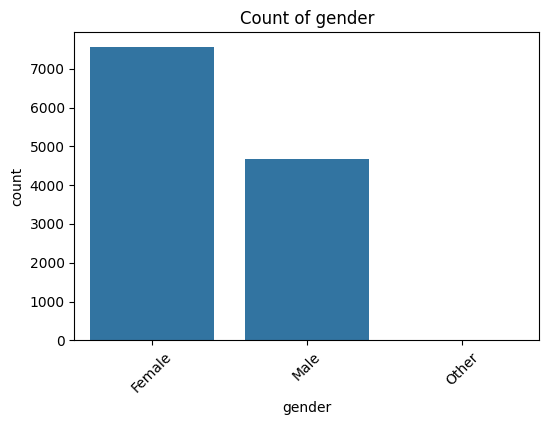

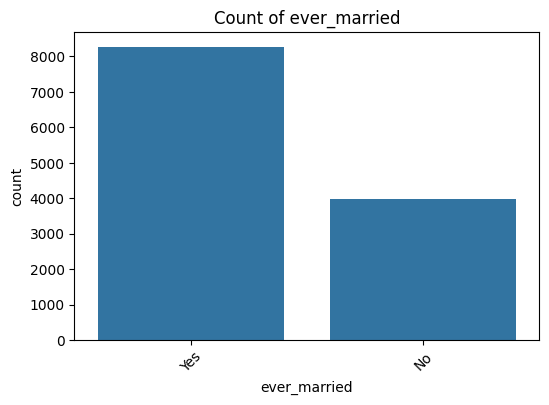

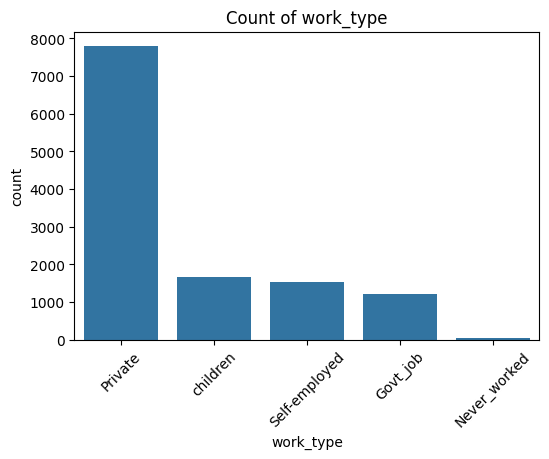

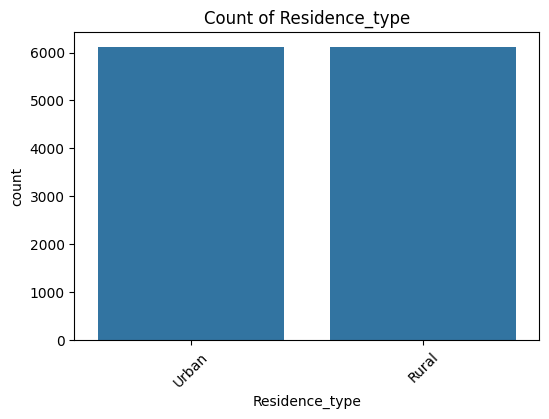

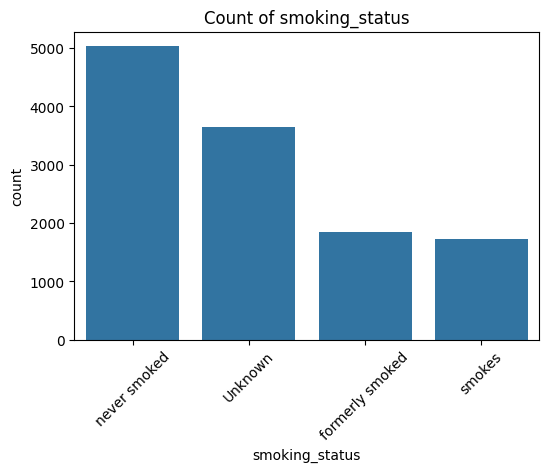

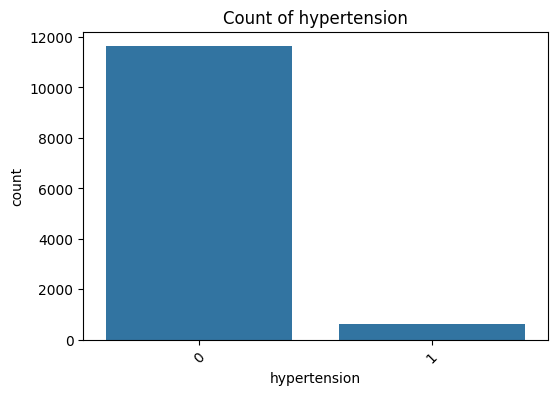

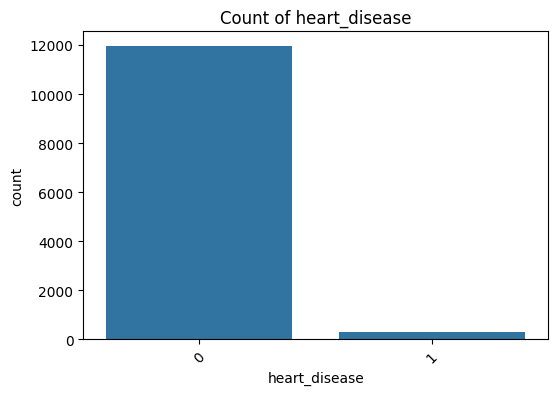

In [41]:
# Categorical Features: Count Plots
# Visualize the count of each category in categorical columns
for col in cat_cols + cat_binary_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=train, x=col, order=train[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
    plt.show()

* *Observations:*
* The prevalence of heart disease and hypertension is relatively low in the dataset.
* A majority of individuals in the training set have never smoked.
* The distribution of residence type is balanced between rural and urban areas.
* The "Private" work type category constitutes the largest proportion of the training set.
* The majority of individuals are "ever married" compared to those who have never married.
* Females make up a larger portion of the dataset than males.

**4.13 Relationship with Target (Stroke)**  


4.13.1 Numerical features vs stroke

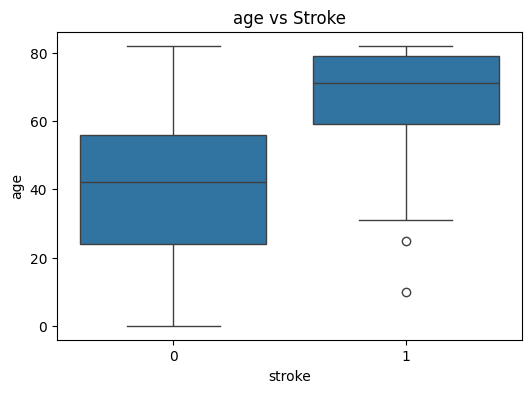

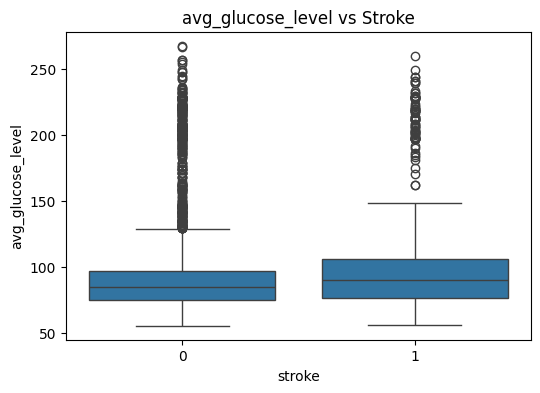

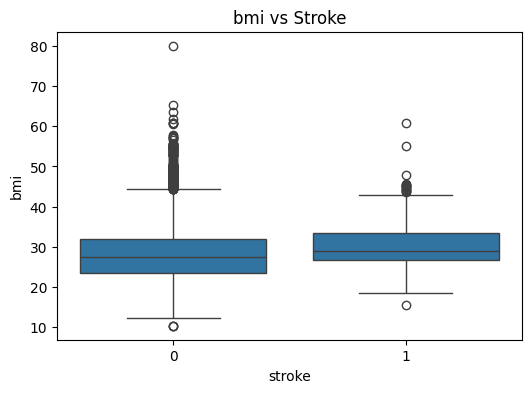

In [42]:
# Numerical features vs stroke
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train, x='stroke', y=col)
    plt.title(f'{col} vs Stroke')
    plt.show()

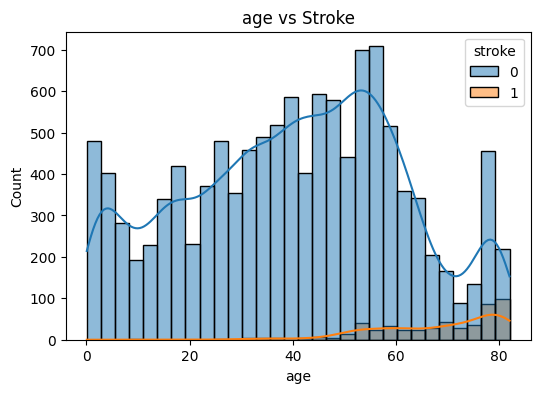

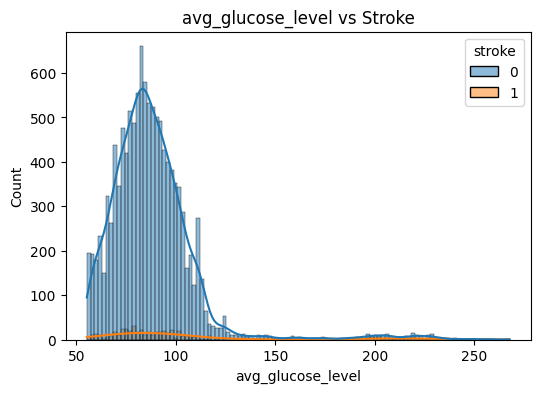

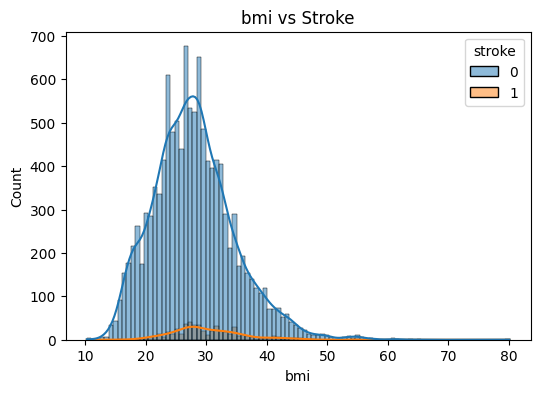

In [43]:
# Visualize the distribution of numerical features with respect to the target variable (stroke)
# This helps to understand how each numerical feature is distributed across the two classes of the target variable
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=train,x=col, hue='stroke', kde=True)
    plt.title(f'{col} vs Stroke')
    plt.show()

* **Observation:** With the high values of BMI value stroke chances are more

4.13.2 Categorical Features: Count Plots

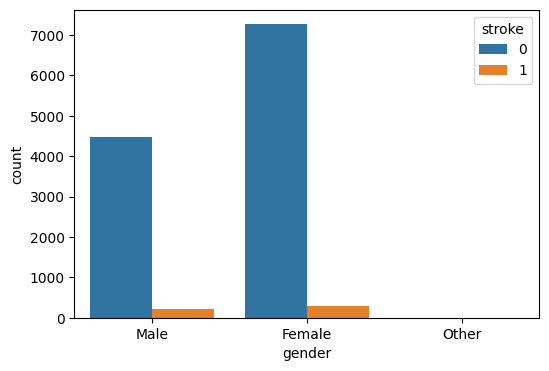

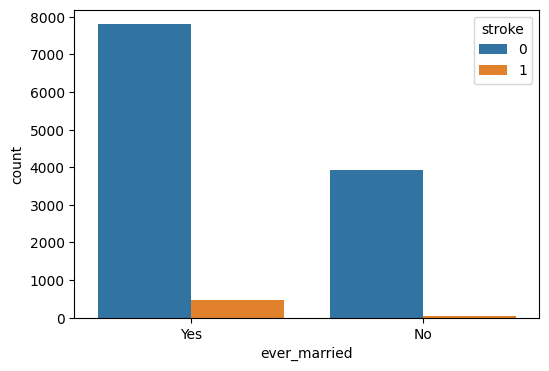

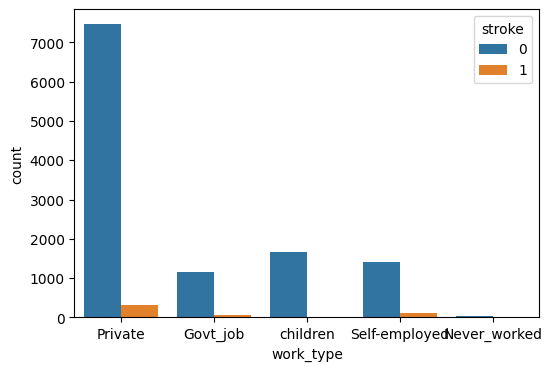

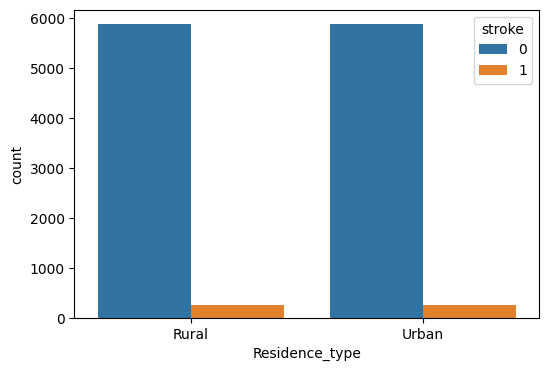

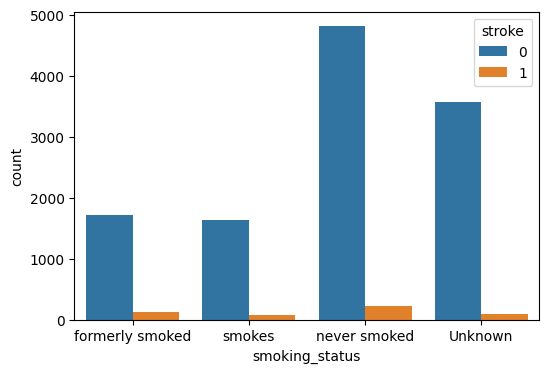

In [44]:
# Categorical Features: Count Plots
# Visualize the count of each category in categorical columns
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=train, x=col, hue='stroke')
    plt.show()

* **Obervations:**  
* Private sector job holders are having high chance of stroke
* Female are having high chance of stroke
* Married person's having high chances of stroke

4.13.3 Coorelation check between the features

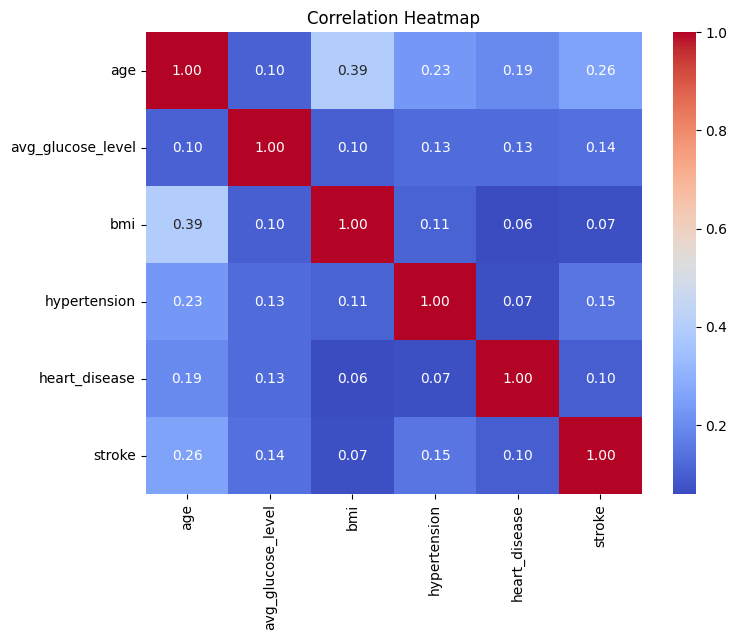

In [45]:
# Coorelation check between the features
corr_features = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke']
corr_matrix = train[corr_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

* **Observations:**
* There is weak correlation between the features and the target variable
* 'avg_glucose_level' and 'bmi' have a moderate correlation with 'stroke
* High correlation between 'age' and 'stroke' 0.39
* Rest features are having coorelation < 0.39
* No conclusive statistical insights for the hitmap